# **Projet P6 - une solution**

Analyse du jeu de données [Census Dataset](https://archive.ics.uci.edu/ml/datasets/census+income) à partir du dépot officiel : UCI Machine Learning Repository.  

Il y a 3 datasets:
- Le training set : [adult.data](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data)
- La description du dataset : [adult.names](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names)
- Le test set : [adult.test](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test)

## **1. Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from matplotlib import pyplot as plt
import os
import pickle

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier

## **2. Charger les données**

On peut télécharger les données _"à la main"_ mais on peut aussi utiliser le module requests pour aller les chercher directement sur UCI Machine Learning Repository. L'intérêt est de pouvoir mettre à jour directement les données s'il y avait des modifications lorsqu'on réexécute le notebook. Intérêt limité dans notre cas puisque le jeu date de 1996 et n'est plus vraiment mis à jour. C'est toujours un bon exercice de le faire !

In [2]:
# La cellule est commentée car les données ont été chargées récemment ce n'est pas la peine de recommencer
"""def load_data(path, urls):
    if not os.path.exists(path):
        os.mkdir(path)

    for url in urls:
        data = requests.get(url).content
        filename = os.path.join(path, os.path.basename(url))
        with open(filename, "wb") as file:
            file.write(data)

urls = ["http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names",
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"]

load_data('data', urls)"""

'def load_data(path, urls):\n    if not os.path.exists(path):\n        os.mkdir(path)\n\n    for url in urls:\n        data = requests.get(url).content\n        filename = os.path.join(path, os.path.basename(url))\n        with open(filename, "wb") as file:\n            file.write(data)\n\nurls = ["http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",\n        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names",\n        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"]\n\nload_data(\'data\', urls)'

**Quelques remarques :**
>- Les jeu de données n'ont pas de noms de colonnes par défaut, il faut donc les ajouter manuellement. On les récupère dans le data.names
>- Comme évoqué, certaines observations on des espaces avant et après les valeurs. On peut passer une expression régulière pour le paramètre **sep** de la fonction [read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html). " \*, \*"
>- Les valeurs manquantes sont indiquées par **'?'**. une fois qu'on l'a remarqué on peut fixer le paramètre **na_values** 
>- Le jeu de données test contient une première ligne bizarre donc on peut ajouter le paramètre **skiprows=1**

In [3]:
columns = ["age", "workClass", "fnlwgt", "education", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "capital_gain",
           "capital_loss", "hours_per_week", "native_country", "income"]

train_data = pd.read_csv('data/adult.data', names = columns, sep=' *, *', na_values='?', engine='python')
test_data = pd.read_csv('data/adult.test', names = columns, sep=' *, *', skiprows =1, na_values='?', engine='python')

In [4]:
train_data.head()

,age,workClass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
test_data.head()

,age,workClass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K.


**ATTENTION** on peut remarquer que la colonne *income* de test_data a un "." à la fin. Il ne faudra pas l'oublier au moment d'encoder la variable y en 0-1.

## **3. Analyse exploratoire**

### **Informations générales sur le dataset**

On cherche les valeurs manquantes qu'il va falloir au choix supprimer ou imputer.

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workClass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16281 non-null  int64 
 1   workClass       15318 non-null  object
 2   fnlwgt          16281 non-null  int64 
 3   education       16281 non-null  object
 4   education_num   16281 non-null  int64 
 5   marital_status  16281 non-null  object
 6   occupation      15315 non-null  object
 7   relationship    16281 non-null  object
 8   race            16281 non-null  object
 9   sex             16281 non-null  object
 10  capital_gain    16281 non-null  int64 
 11  capital_loss    16281 non-null  int64 
 12  hours_per_week  16281 non-null  int64 
 13  native_country  16007 non-null  object
 14  income          16281 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


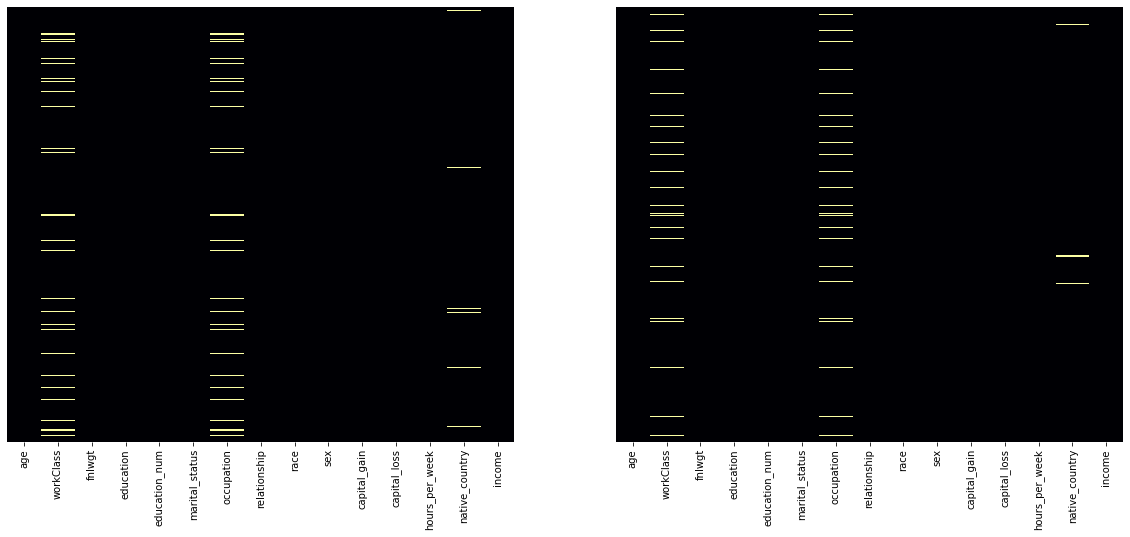

In [8]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
sns.heatmap(train_data.isnull(), yticklabels=False, cbar=False, cmap='inferno', ax=ax[0]);
sns.heatmap(test_data.isnull(), yticklabels=False, cbar=False, cmap='inferno', ax=ax[1]);

**Quelques remarques**
>- Nombre d'observations : **32561** dans le train set et **16281** dans le test set
>- Présence de variables catégoriques et numériques
>- Les colonnes **workClass**, **occupation**, **native_country** ont des valeurs manquantes

On va pas faire l'imputation des valeurs manquantes dans cette étape mais directement dans la Pipeline de preprocessing que l'on créera un peu plus loin. Ce n'est pas du tout obligatoire et on pourrait choisir de s'en occuper ici et maintenant.

### **Un peu de visualisation**

On regarde maintenant plus en détail nos variables : leur distribution, leur plage de valeurs, des éventuelles corrélations

#### **Cas des variables numériques**

On peut sélectionner les valeurs numériques avec la fonction [select_dtypes](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.select_dtypes.html)

In [9]:
varnum = train_data.select_dtypes(include=['int'])
varnum.columns

Index(['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week'],
      dtype='object')

**Quelques remarques**
> Les variables *age*, *education_num* et *hours_per_week* sont suffisament explicites. Pour les autres :
>- *fnlwgt* : poids d'échantillonage, on ne s'en servira pas ici
>- *capital_gain/loss* : revenu ou perte dûs à d'autres sources que le salaire

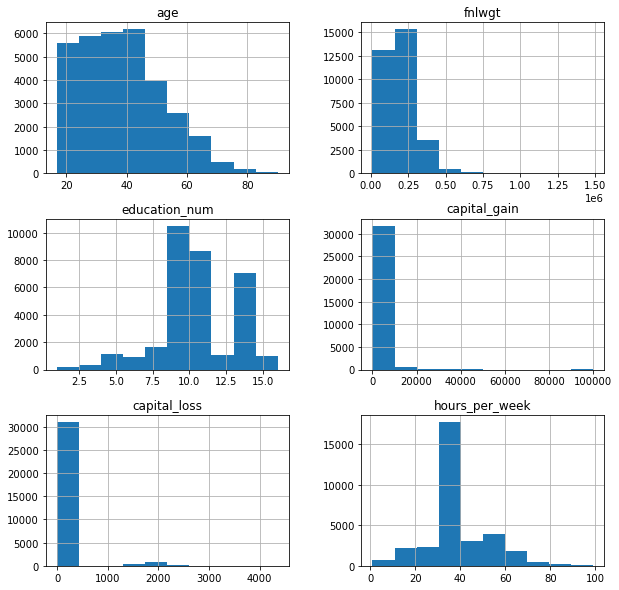

In [10]:
varnum.hist(figsize=(10,10));

In [11]:
varnum.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


**Quelques remarques**
>- Pas de valeurs manquantes pour les variables numériques
>- Échelles très différentes et donc nécessité de passer par l'étape *feature scaling*

#### **Cas des variables catégoriques**

In [12]:
varcat = train_data.select_dtypes(include=['object'])
varcat.columns

Index(['workClass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'native_country', 'income'],
      dtype='object')

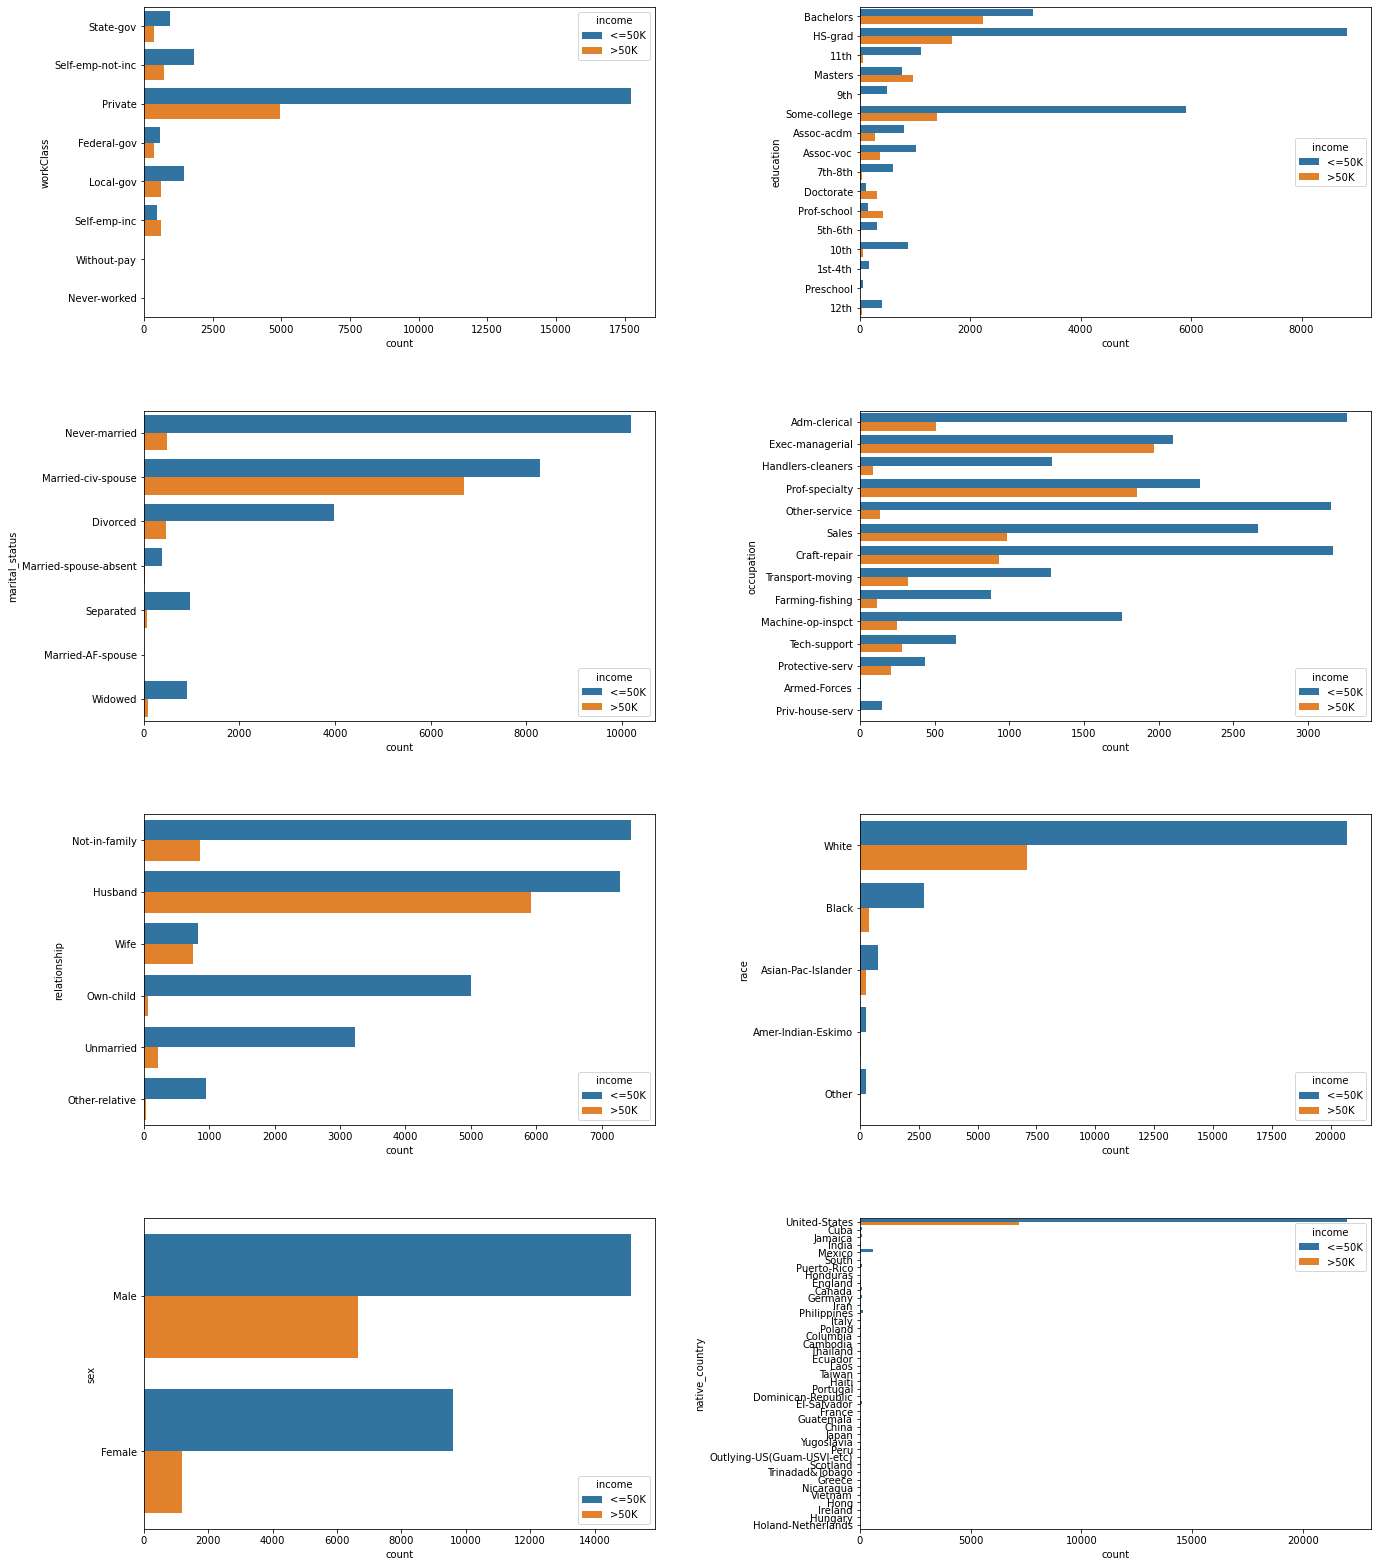

In [13]:
fig = plt.figure(figsize=(22,28))
plt.subplots_adjust(wspace=0.4, hspace=0.3)
for i in range(varcat.shape[1]-1):
    var = varcat.columns[i]
    fig.add_subplot(4,2,i+1)
    sns.countplot(y=var, hue='income', data=varcat);

**Quelques remarques**
> Les variables *workClass*, *occupation* et *native_country* ont des valeurs manquantes : pour simplifier, on va imputer la valeur la plus fréquente. Une stratégie pourrait être de mettre en place en kNN en prenant comme train set les données complètes et affecter à chaque individu le mode des plus proches voisins.

#### **Nettoyage des datasets et création de X et y**

On a choisi de ne pas conserver : *education* et *fnlwgt*. Par ailleurs, on peut ici construire notre matrice X des variables indépendantes et y le vecteur contenant la variable prédite. De plus, notre variable prédite prend 2 valeurs : "<=50K" et ">50K". On va recoder donc cette variable en 0 et 1 directement.

In [14]:
y_train = train_data["income"].apply(lambda x:0 if x=='<=50K' else 1)
y_test = test_data["income"].apply(lambda x:0 if x=='<=50K.' else 1) #on n'oublie pas le "."

In [15]:
X_train = train_data.drop(['fnlwgt', 'education', 'income'], axis=1)
X_test = test_data.drop(['fnlwgt', 'education', 'income'], axis=1)

In [16]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(32561, 12) (32561,) (16281, 12) (16281,)


In [17]:
y_test.value_counts()

0    12435
1     3846
Name: income, dtype: int64

## **4. Pipeline pour le preprocessing**

Il va falloir gérer différement les valeurs catégoriques et numériques. Les variables numériques doivent être *"mises à l'échelle"* alors que les variables catégoriques doivent être encodées en dummies.

Comme évoqué, on peut utiliser pour ces enchaînements de processus un [Pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). Parfois, on peut aussi avoir besoin de construire nous-même nos *transformers* qui pourront être utilisés directement dans un Pipeline mais ce ne devrait pas être le cas ici.

Pour les variables numériques, il n'y a pas d'imputation à faire donc on a juste à utiliser un scaler (StandardScaler ou RobustScaler selon la décision prise). En revanche pour les variables catégoriques, il faut d'abord imputer les valeurs manquantes puis encoder numériquement les variables. On va donc d'abord créer une Pipeline pour la gestion des variables catégoriques qu'on pourra ensuite intégrer dans un objet de la classe ColumnTransformer.

In [18]:
# la Pipeline pour les variables catégoriques
cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first')) #handle_unknown='ignore' paramètre pour ignore les nouvelles modalités s'il y en a dans le test set
])

In [19]:
# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), make_column_selector(dtype_include=np.number)),
    ("cat", cat_pipe, make_column_selector(dtype_exclude=np.number))
])

On ajuste notre proprecessor sur X_train et on transforme ensuite X_train et X_test avec le même preprocessor.

In [20]:
# Preprocessor appliqué aux données X_train et X_test
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

## **5. Entraînement du modèle**

In [21]:
reglog = LogisticRegression(solver='liblinear', max_iter=1000)

In [22]:
reglog.fit(X_train_processed, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [23]:
# On peut aussi faire une nouvelle pipeline contenant le processor + estimator 
reglog2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', max_iter=1000))
])

# On ajuste ensuite cette pipeline sur X_train
reglog2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f2c2eb14e80>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f2c2eb14df0>)])),
                ('classifier',
                 LogisticRegression(max_iter=1000, solver='liblinear'))])

## **6. Évaluation du modèle**

In [24]:
print('train =', reglog.score(X_train_processed,y_train), 'et test =', reglog.score(X_test_processed,y_test))

train = 0.8516016092871841 et test = 0.8522818008721823


In [25]:
print('train =', reglog2.score(X_train,y_train), 'et test =', reglog2.score(X_test,y_test))

train = 0.8516016092871841 et test = 0.8522818008721823


In [26]:
print(classification_report(y_test,reglog.predict(X_test_processed)))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91     12435
           1       0.73      0.60      0.66      3846

    accuracy                           0.85     16281
   macro avg       0.81      0.76      0.78     16281
weighted avg       0.85      0.85      0.85     16281



Comme on va vraisemblablement tester plusieurs modèles et les évaluer on peut définir une fonction qui affiche un certain nombre d'informations et de graphes pour évaluer un modèle de classification donné. On pourra y mettre :
- les mesures de l'accuracy, précision et recall
- la matrice de confusion
- la courbe ROC avec l'AUC

In [27]:
def evaluation(model):
    y_pred = model.predict(X_test_processed)
    proba_1 = model.predict_proba(X_test_processed)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, proba_1, pos_label=1, drop_intermediate=False)
    aucf = auc(fpr, tpr)
    cm = confusion_matrix(y_pred, y_test)
    accuracy = accuracy_score(y_pred, y_test)
    precision, rappel = precision_recall_fscore_support(y_test, y_pred, pos_label=1, average='macro')[0:2]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.plot(fpr, tpr, label='auc=%1.5f' % aucf)
    ax1.set_title('Courbe ROC')
    ax1.text(0.5, 0.3, "plus mauvais que\nle hasard dans\ncette zone")
    ax1.legend()

    sns.heatmap(cm, annot=True, fmt="d", linewidths=0.5, cmap="YlGnBu", ax=ax2)
    ax2.set_xlabel('Classes prédites')
    ax2.set_ylabel('Classes réelles')

    plt.suptitle("Accuracy = {:0.5} ; Precision = {:0.5} ; Rappel = {:0.5}".format(accuracy,precision,rappel), fontsize = 15 )
    plt.show()

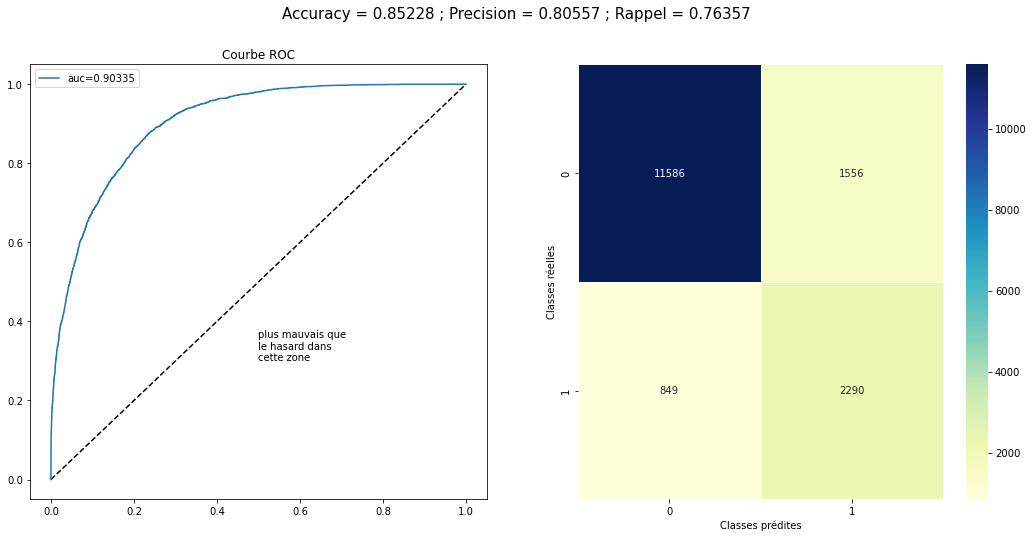

In [28]:
evaluation(reglog)

## **7. Validation Croisée**

On va utiliser une validation croisée ave la méthode [StratifiedKFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) et [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) pour calculer le score sur chaque découpage de la validation croisée. Le paramètre **cv** détermine la méthode utilisée.

In [29]:
scores = cross_val_score(reglog, X_train_processed, y_train, cv=5)
print(scores)
print(np.mean(scores))

[0.84784278 0.84966216 0.85334767 0.85396192 0.85242629]
0.8514481620769045


## **8. Affinage des hyperparamètres**

Les paramètres par défaut de la régression logistique sont les suivants :  
LogisticRegression(*C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False*)
          
On peut utiliser la validation croisée et plus particulièrement la classe [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) pour affiner les hyperparamètres en testant le modèle pour différentes valeurs de ces paramètres que l'on spécifie.          

In [30]:
# On crée notre liste d'hyperparamètres à tester sous forme de dictionnaire qui sera ensuite passé en paramètre de GridSearchCV
hyperparam = dict(C=[0.01,0.1,1,10,100,1000], penalty=['l1', 'l2'])

In [31]:
reglog_cv = GridSearchCV(estimator = reglog, param_grid = hyperparam, cv=StratifiedKFold(5))
reglog_cv.fit(X_train_processed, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

In [32]:
# Affichage des hyperparamètres optimaux et de l'accuracy pour chaque jeu d'hyperparamètres
print("Meilleurs hyperparamètres sur le jeu d'entraînement:")
print(reglog_cv.best_params_)
print("\nRésultats de la validation croisée :")
for mean, std, params in zip(
        reglog_cv.cv_results_['mean_test_score'], # score moyen
        reglog_cv.cv_results_['std_test_score'],  # écart-type du score
        reglog_cv.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("'accuracy' = {:.5f} (+/-{:.03f}) for {}".format(mean,std*2,params))

Meilleurs hyperparamètres sur le jeu d'entraînement:
{'C': 1, 'penalty': 'l2'}

Résultats de la validation croisée :
'accuracy' = 0.84506 (+/-0.008) for {'C': 0.01, 'penalty': 'l1'}
'accuracy' = 0.84838 (+/-0.005) for {'C': 0.01, 'penalty': 'l2'}
'accuracy' = 0.85056 (+/-0.006) for {'C': 0.1, 'penalty': 'l1'}
'accuracy' = 0.85086 (+/-0.005) for {'C': 0.1, 'penalty': 'l2'}
'accuracy' = 0.85093 (+/-0.005) for {'C': 1, 'penalty': 'l1'}
'accuracy' = 0.85145 (+/-0.005) for {'C': 1, 'penalty': 'l2'}
'accuracy' = 0.85086 (+/-0.005) for {'C': 10, 'penalty': 'l1'}
'accuracy' = 0.85093 (+/-0.004) for {'C': 10, 'penalty': 'l2'}
'accuracy' = 0.85074 (+/-0.004) for {'C': 100, 'penalty': 'l1'}
'accuracy' = 0.85071 (+/-0.005) for {'C': 100, 'penalty': 'l2'}
'accuracy' = 0.85068 (+/-0.005) for {'C': 1000, 'penalty': 'l1'}
'accuracy' = 0.85074 (+/-0.004) for {'C': 1000, 'penalty': 'l2'}


## **9. Sauvegarde du modèle avec le module pickle**

Maintenant qu'on a fait tout le boulot, on pourrait vouloir sauvegarder le modèle pour le réutiliser plus tard pour prédire de nouvelles données par exemple. On peut faire ça avec [pickle](https://docs.python.org/2/library/pickle.html).

In [33]:
# sauvegarder le modèle
filename = 'logistique_final.sav'
pickle.dump(reglog_cv.best_estimator_, open(filename, 'wb'))

In [34]:
# recharger le modèle
logisitique_sauvegarde = pickle.load(open(filename, 'rb')) 
print(logisitique_sauvegarde)

LogisticRegression(C=1, max_iter=1000, solver='liblinear')


## **10. Autres modèles**

### **Un kNN**

On effectue directement l'étape de validation croisée pour déterminer les meilleurs hyperparamètres. 

In [35]:
# Cellule commentée car temps d'exécution un peu long : on obtient k=22
# On fixe les valeurs des hyperparamètres à tester
# On peut tester 'metric':['euclidean','manhattan'], 'weights':['uniform','distance'] mais c'est long
# et on obtient 'euclidean' et 'uniform' comme meilleurs param
"""hyperparam = {'n_neighbors':list(range(2,41,2))}
knn_cv = GridSearchCV(KNeighborsClassifier(), param_grid=hyperparam, cv=4, scoring='accuracy')
knn_cv.fit(X_train_processed, y_train)

print("Meilleurs hyperparamètres sur le jeu d'entraînement:")
print(knn_cv.best_params_)
print("\nRésultats de la validation croisée :")
for mean, std, params in zip(knn_cv.cv_results_['mean_test_score'],knn_cv.cv_results_['std_test_score'], knn_cv.cv_results_['params']):
    print("'accuracy' = {:.5f} (+/-{:.03f}) for {}".format(mean,std*2,params))"""

'hyperparam = {\'n_neighbors\':list(range(2,41,2))}\nknn_cv = GridSearchCV(KNeighborsClassifier(), param_grid=hyperparam, cv=4, scoring=\'accuracy\')\nknn_cv.fit(X_train_processed, y_train)\n\nprint("Meilleurs hyperparamètres sur le jeu d\'entraînement:")\nprint(knn_cv.best_params_)\nprint("\nRésultats de la validation croisée :")\nfor mean, std, params in zip(knn_cv.cv_results_[\'mean_test_score\'],knn_cv.cv_results_[\'std_test_score\'], knn_cv.cv_results_[\'params\']):\n    print("\'accuracy\' = {:.5f} (+/-{:.03f}) for {}".format(mean,std*2,params))'

In [36]:
knn = KNeighborsClassifier(n_neighbors=22)
knn.fit(X_train_processed,y_train)

KNeighborsClassifier(n_neighbors=22)

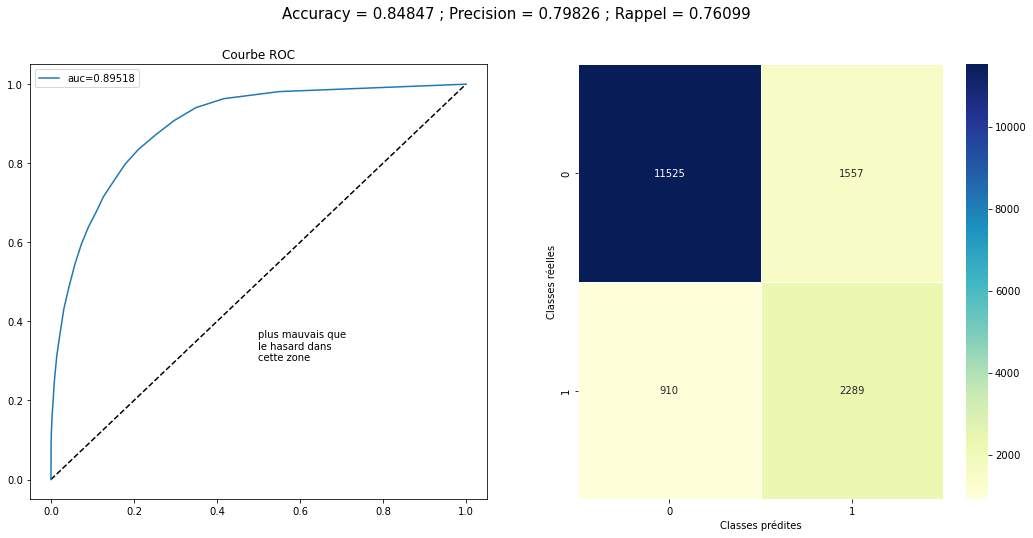

In [37]:
# Évaluation du modèle
evaluation(knn)

### **Un SVM**

In [38]:
%%time
# Attention,c'est un peu long. On pourrait aussi tester d'autres hyperparamètres (kernel, gamma, etc...)
hyperparam = {'C': [0.001, 1, 100, 1000]}
svm_cv = GridSearchCV(SVC(kernel = 'rbf', random_state=0), param_grid=hyperparam, cv=3, scoring='accuracy', n_jobs=-1)
svm_cv.fit(X_train_processed, y_train)

# Affichage des hyperparamètres optimaux et de l'accuracy pour chaque jeu d'hyperparamètres
print("Meilleurs hyperparamètres sur le jeu d'entraînement:")
print(svm_cv.best_params_)
print("\nRésultats de la validation croisée :")
for mean, std, params in zip(svm_cv.cv_results_['mean_test_score'], svm_cv.cv_results_['std_test_score'], svm_cv.cv_results_['params']):
    print("'accuracy' = {:.5f} (+/-{:.03f}) for {}".format(mean,std*2,params))

Meilleurs hyperparamètres sur le jeu d'entraînement:
{'C': 1}

Résultats de la validation croisée :
'accuracy' = 0.75919 (+/-0.000) for {'C': 0.001}
'accuracy' = 0.85688 (+/-0.006) for {'C': 1}
'accuracy' = 0.84773 (+/-0.004) for {'C': 100}
'accuracy' = 0.83726 (+/-0.004) for {'C': 1000}
CPU times: user 19.8 s, sys: 208 ms, total: 20 s
Wall time: 4min 55s


On peut ajouter le paramètre `probability=True` pour avoir un calcul des probabilités et pouvoir tracer la courbe ROC. Pour rappel, ce calcul se fait par validation croisée en utilisant une régression logistique. Plusieurs problèmes :
- les probabilités obtenues ne sont pas toujours en accord avec la prédiction du classifieur SVM
- cela augmente considérablement le temps d'exécution

In [39]:
svm = SVC(C=1, probability=True)
svm.fit(X_train_processed, y_train)

SVC(C=1, probability=True)

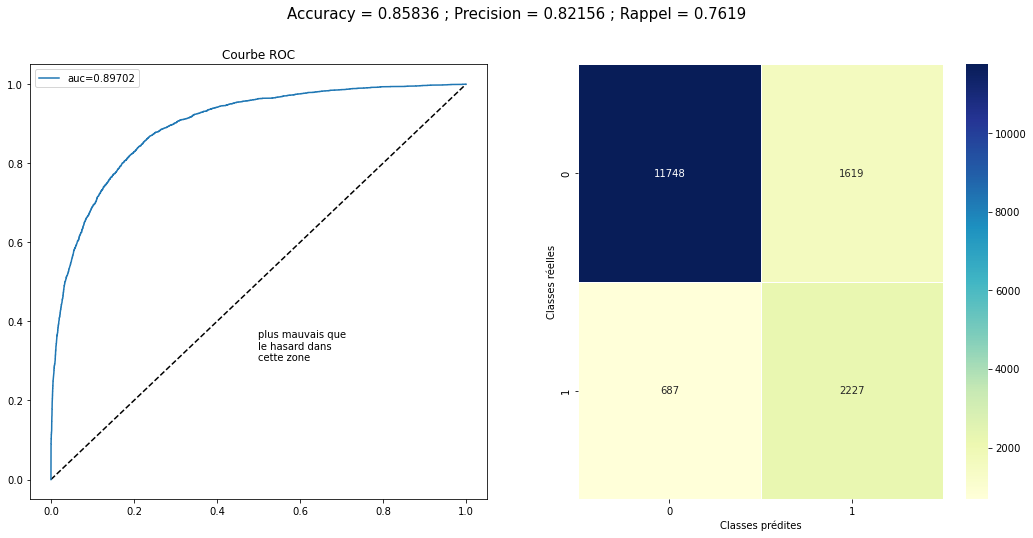

In [40]:
evaluation(svm)

### **Forêts aléatoires**

In [41]:
%%time
param_grid = {
    'max_depth': [50, 100, 150],
    'n_estimators': [100, 250, 500]
}

rf_cv = GridSearchCV(RandomForestClassifier(), param_grid = param_grid, cv = 3, n_jobs = -1)
rf_cv.fit(X_train_processed, y_train)


# Affichage des hyperparamètres optimaux et de l'accuracy pour chaque jeu d'hyperparamètres
print("Meilleurs hyperparamètres sur le jeu d'entraînement:")
print(rf_cv.best_params_)
print("\nRésultats de la validation croisée :")
for mean, std, params in zip(rf_cv.cv_results_['mean_test_score'],
                             rf_cv.cv_results_['std_test_score'],
                             rf_cv.cv_results_['params']):
    print("'accuracy' = {:.5f} (+/-{:.03f}) for {}".format(mean,std*2,params))

Meilleurs hyperparamètres sur le jeu d'entraînement:
{'max_depth': 50, 'n_estimators': 500}

Résultats de la validation croisée :
'accuracy' = 0.84770 (+/-0.006) for {'max_depth': 50, 'n_estimators': 100}
'accuracy' = 0.84914 (+/-0.005) for {'max_depth': 50, 'n_estimators': 250}
'accuracy' = 0.84957 (+/-0.006) for {'max_depth': 50, 'n_estimators': 500}
'accuracy' = 0.84853 (+/-0.005) for {'max_depth': 100, 'n_estimators': 100}
'accuracy' = 0.84942 (+/-0.005) for {'max_depth': 100, 'n_estimators': 250}
'accuracy' = 0.84893 (+/-0.007) for {'max_depth': 100, 'n_estimators': 500}
'accuracy' = 0.84746 (+/-0.006) for {'max_depth': 150, 'n_estimators': 100}
'accuracy' = 0.84844 (+/-0.005) for {'max_depth': 150, 'n_estimators': 250}
'accuracy' = 0.84865 (+/-0.004) for {'max_depth': 150, 'n_estimators': 500}
CPU times: user 1min 36s, sys: 143 ms, total: 1min 36s
Wall time: 6min 29s


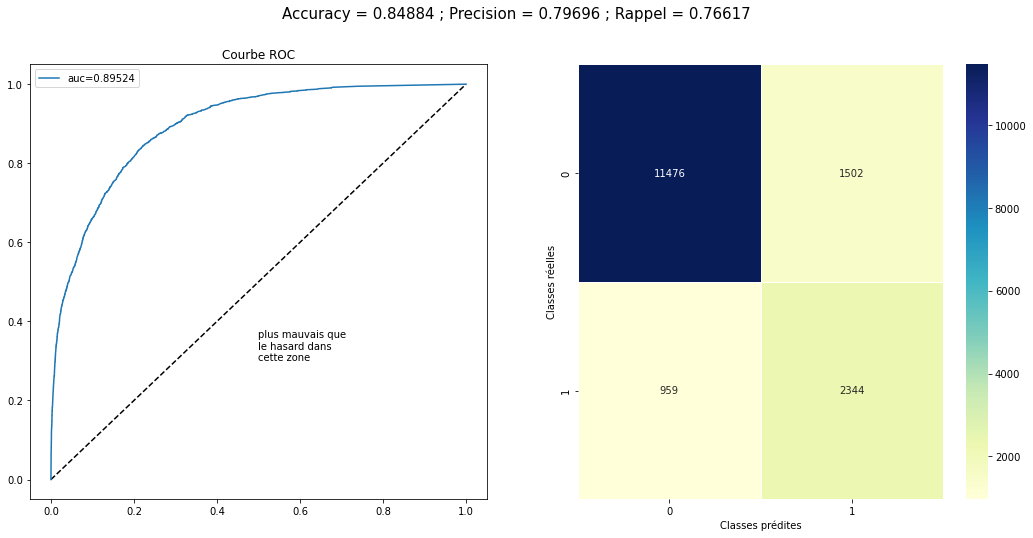

In [42]:
# Évaluation du modèle
evaluation(rf_cv.best_estimator_)

### **Gradient Boost**

In [43]:
param_grid = {
    'max_depth': [5, 50, 90],
    'n_estimators': [100, 500],
}

gb_cv = GridSearchCV(GradientBoostingClassifier(), param_grid = param_grid, cv = 3, n_jobs = -1)
gb_cv.fit(X_train_processed, y_train)

# Affichage des hyperparamètres optimaux et de l'accuracy pour chaque jeu d'hyperparamètres
print("Meilleurs hyperparamètres sur le jeu d'entraînement:")
print(gb_cv.best_params_)
print("\nRésultats de la validation croisée :")
for mean, std, params in zip(gb_cv.cv_results_['mean_test_score'],
                             gb_cv.cv_results_['std_test_score'],
                             gb_cv.cv_results_['params']):
    print("'accuracy' = {:.5f} (+/-{:.03f}) for {}".format(mean,std*2,params))

Meilleurs hyperparamètres sur le jeu d'entraînement:
{'max_depth': 5, 'n_estimators': 100}

Résultats de la validation croisée :
'accuracy' = 0.87113 (+/-0.005) for {'max_depth': 5, 'n_estimators': 100}
'accuracy' = 0.86948 (+/-0.004) for {'max_depth': 5, 'n_estimators': 500}
'accuracy' = 0.81849 (+/-0.007) for {'max_depth': 50, 'n_estimators': 100}
'accuracy' = 0.82651 (+/-0.010) for {'max_depth': 50, 'n_estimators': 500}
'accuracy' = 0.81843 (+/-0.008) for {'max_depth': 90, 'n_estimators': 100}
'accuracy' = 0.82666 (+/-0.011) for {'max_depth': 90, 'n_estimators': 500}


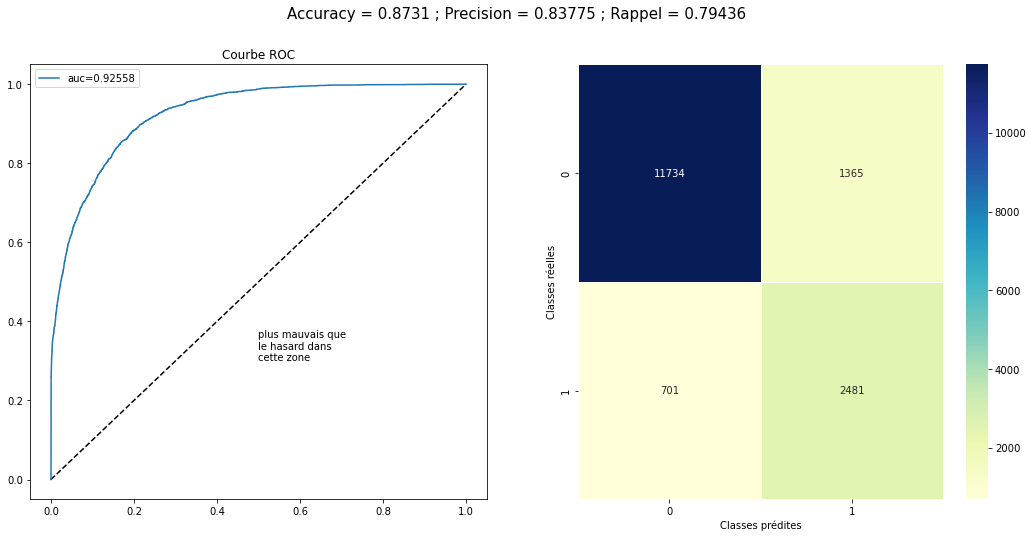

In [44]:
# Évaluation du modèle
evaluation(gb_cv.best_estimator_)

### **XG Boost**

In [51]:
param_grid = {
     'n_estimators': [100, 500, 1000],
     'eta': [0.01, 0.1, 0.3],
     'max_depth': [3, 6],
     'lambda': [0.1, 1, 2]
}

xgb_cv = GridSearchCV(XGBClassifier(eval_metric='logloss', use_label_encoder=False), param_grid = param_grid, cv = 3, n_jobs = -1)
xgb_cv.fit(X_train_processed, y_train)

# Affichage des hyperparamètres optimaux et de l'accuracy pour chaque jeu d'hyperparamètres
print("Meilleurs hyperparamètres sur le jeu d'entraînement:")
print(xgb_cv.best_params_)
print("\nRésultats de la validation croisée :")
for mean, std, params in zip(xgb_cv.cv_results_['mean_test_score'],
                             xgb_cv.cv_results_['std_test_score'],
                             xgb_cv.cv_results_['params']):
    print("'accuracy' = {:.5f} (+/-{:.03f}) for {}".format(mean,std*2,params))

Meilleurs hyperparamètres sur le jeu d'entraînement:
{'eta': 0.1, 'lambda': 2, 'max_depth': 3, 'n_estimators': 1000}

Résultats de la validation croisée :
'accuracy' = 0.84383 (+/-0.008) for {'eta': 0.01, 'lambda': 0.1, 'max_depth': 3, 'n_estimators': 100}
'accuracy' = 0.85701 (+/-0.005) for {'eta': 0.01, 'lambda': 0.1, 'max_depth': 3, 'n_estimators': 500}
'accuracy' = 0.86324 (+/-0.006) for {'eta': 0.01, 'lambda': 0.1, 'max_depth': 3, 'n_estimators': 1000}
'accuracy' = 0.85919 (+/-0.007) for {'eta': 0.01, 'lambda': 0.1, 'max_depth': 6, 'n_estimators': 100}
'accuracy' = 0.86640 (+/-0.007) for {'eta': 0.01, 'lambda': 0.1, 'max_depth': 6, 'n_estimators': 500}
'accuracy' = 0.87150 (+/-0.005) for {'eta': 0.01, 'lambda': 0.1, 'max_depth': 6, 'n_estimators': 1000}
'accuracy' = 0.84383 (+/-0.008) for {'eta': 0.01, 'lambda': 1, 'max_depth': 3, 'n_estimators': 100}
'accuracy' = 0.85673 (+/-0.005) for {'eta': 0.01, 'lambda': 1, 'max_depth': 3, 'n_estimators': 500}
'accuracy' = 0.86333 (+/-0.007)

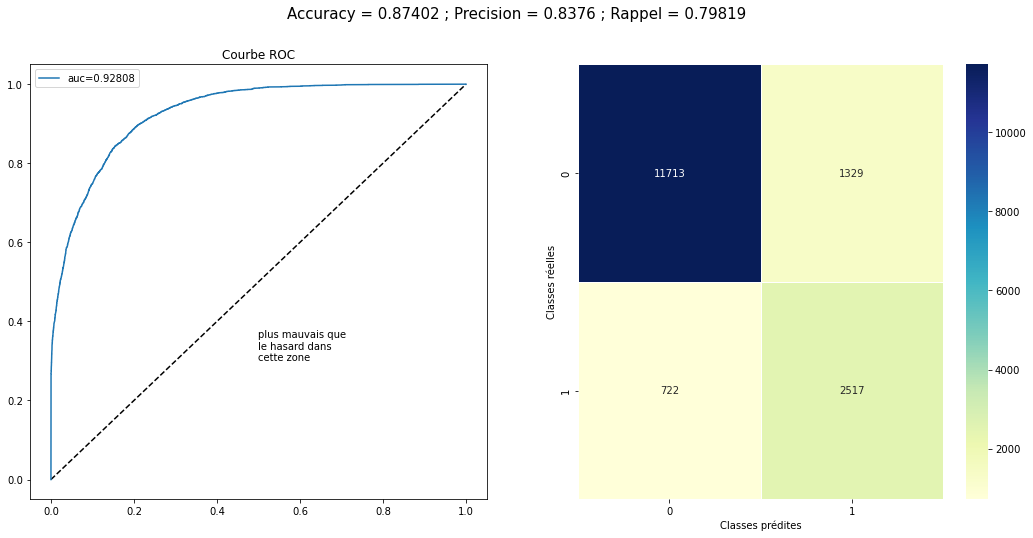

In [52]:
# Évaluation du modèle
evaluation(xgb_cv.best_estimator_)